In [1]:
import datetime
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### train_users_2.csv - the training set of users （训练数据）

### test_users.csv - the test set of users （测试数据）

#### 数据字典
1. id: user id （用户id）

2. date_account_created（帐号注册时间）: the date of account creation

3. timestamp_first_active（首次活跃时间）: timestamp of the first activity, note that it can be earlier than date_account_created or date_first_booking because a user can search before signing up

4. date_first_booking（首次订房时间）: date of first booking

5. gender（性别）

6. age（年龄）

7. signup_method（注册方式）

8. signup_flow（注册页面）: the page a user came to signup up from

9. language（语言）: international language preference

10. affiliate_channel（付费市场渠道）: what kind of paid marketing

11. affiliate_provider（付费市场渠道名称）: where the marketing is e.g. google, craigslist, other

12. first_affiliate_tracked（注册前第一个接触的市场渠道）: whats the first marketing the user interacted with before the signing up

13. signup_app（注册app）

14. first_device_type(设备类型)

15. first_browser（浏览器类型）

16. country_destination（订房国家-需要预测的量）: this is the target variable you are to predict


### sessions.csv - web sessions log for users（网页浏览数据）
#### 数据字典

1. user_id（用户id）: to be joined with the column ‘id’ in users table

2. action(用户行为)

3. action_type（用户行为类型）

4. action_detail（用户行为具体）

5. device_type（设备类型）

6. secs_elapsed（停留时长）


In [2]:
train = pd.read_csv("train_users_2.csv")
test = pd.read_csv("test_users.csv")

In [3]:
train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [4]:
print('The columns name of training dataset:\n',train.columns,train.shape)
print("===========================================")
print('The columns name of test dataset:\n',test.columns,test.shape)

The columns name of training dataset:
 Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination'],
      dtype='object') (213451, 16)
The columns name of test dataset:
 Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser'],
      dtype='object') (62096, 15)


### 绘制用户增长曲线

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       213451 non-null  object 
 1   date_account_created     213451 non-null  object 
 2   timestamp_first_active   213451 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   213451 non-null  object 
 5   age                      125461 non-null  float64
 6   signup_method            213451 non-null  object 
 7   signup_flow              213451 non-null  int64  
 8   language                 213451 non-null  object 
 9   affiliate_channel        213451 non-null  object 
 10  affiliate_provider       213451 non-null  object 
 11  first_affiliate_tracked  207386 non-null  object 
 12  signup_app               213451 non-null  object 
 13  first_device_type        213451 non-null  object 
 14  firs

In [6]:
# 更改账户创建时间格式
train['date_account_created'] = pd.to_datetime(train['date_account_created'],errors='coerce')
test['date_account_created'] = pd.to_datetime(test['date_account_created'],errors='coerce')

In [7]:
# 创建客户量的累积数量，计算当天的客户量加上前面所有的客户量
acc_cum = train.groupby('date_account_created')['id'].count().cumsum().reset_index()
acc_cum.head()

,date_account_created,id
0,2010-01-01,1
1,2010-01-02,2
2,2010-01-03,3
3,2010-01-04,6
4,2010-01-05,9


In [8]:
# 计算注册日期距离初始日期的天数
acc_cum['days'] = (acc_cum['date_account_created']- acc_cum['date_account_created'].min()).dt.days
acc_cum.head()

,date_account_created,id,days
0,2010-01-01,1,0
1,2010-01-02,2,1
2,2010-01-03,3,2
3,2010-01-04,6,3
4,2010-01-05,9,4


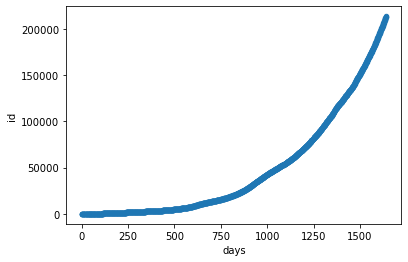

In [9]:
# 画出来每天累积的用户量
acc_cum.plot(kind = 'scatter',x = 'days',y = 'id')

### 绘制日注册数量曲线 

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   id                       213451 non-null  object        
 1   date_account_created     213451 non-null  datetime64[ns]
 2   timestamp_first_active   213451 non-null  int64         
 3   date_first_booking       88908 non-null   object        
 4   gender                   213451 non-null  object        
 5   age                      125461 non-null  float64       
 6   signup_method            213451 non-null  object        
 7   signup_flow              213451 non-null  int64         
 8   language                 213451 non-null  object        
 9   affiliate_channel        213451 non-null  object        
 10  affiliate_provider       213451 non-null  object        
 11  first_affiliate_tracked  207386 non-null  object        
 12  signup_app      

In [11]:
# 计算每个注册日期有多少人注册账户
dac_train = train.date_account_created.value_counts()
dac_test = test.date_account_created.value_counts()

In [12]:
dac_train

2014-05-13    674
2014-06-24    670
2014-06-25    636
2014-05-20    632
2014-05-14    622
             ... 
2010-01-03      1
2010-01-19      1
2010-02-14      1
2010-01-28      1
2010-06-18      1
Name: date_account_created, Length: 1634, dtype: int64

In [13]:
# 找到所有注册日期值
dac_train_date = dac_train.index
dac_test_date = dac_test.index

In [14]:
# 计算注册日期距离初始日期的天数
dac_train_day = dac_train_date - dac_train_date.min()
dac_test_day = dac_test_date - dac_train_date.min()

In [15]:
dac_train_day

TimedeltaIndex(['1593 days', '1635 days', '1636 days', '1600 days',
                '1594 days', '1601 days', '1614 days', '1627 days',
                '1622 days', '1608 days',
                ...
                  '90 days',    '0 days',   '22 days',  '113 days',
                  '67 days',    '2 days',   '18 days',   '44 days',
                  '27 days',  '168 days'],
               dtype='timedelta64[ns]', length=1634, freq=None)

In [16]:
dac_train.values

array([674, 670, 636, ...,   1,   1,   1], dtype=int64)

In [17]:
dac_train_day.days

Int64Index([1593, 1635, 1636, 1600, 1594, 1601, 1614, 1627, 1622, 1608,
            ...
              90,    0,   22,  113,   67,    2,   18,   44,   27,  168],
           dtype='int64', length=1634)

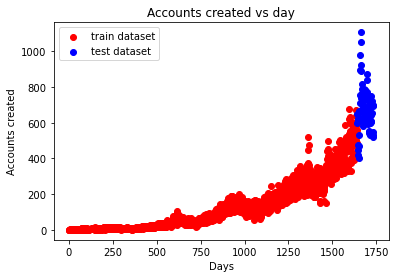

In [18]:
# 做图，横轴是注册日期距离初始日期的天数，纵轴是注册用户量
plt.scatter(dac_train_day.days,dac_train.values,color = 'r',label = 'train dataset')
plt.scatter(dac_test_day.days,dac_test.values,color = 'b',label = 'test dataset')

plt.title("Accounts created vs day")
plt.xlabel("Days")
plt.ylabel("Accounts created")
plt.legend(loc = 'best')

### 定义一个函数，功能为绘制每个类别变量(函数参数中的feature) barplot

In [19]:
# def lookup_feature(feature, data_train = train, data_test = test, figsize=(8,8),saveimg = False): 
#     sns.set()
#     # 提取特征，值计数
#     train_feat = data_train[feature].value_counts()
#     test_feat = data_test[feature].value_counts()
#     # 创建画布和子图
#     fig_feature,ax = plt.subplots(2,1,sharex = True,sharey = True,figsize = figsize)
#     # 画图,分别绘制训练集和测试集图
#     sns.barplot(x = train_feat.index,y = train_feat.values,ax = ax[0],palette='Set1')
#     # 训练集
#     plt.xticks(rotation=90) # x轴标签的旋转角度
#     # 测试集
#     sns.barplot(x = test_feat.index,y = test_feat.values,ax = ax[1],palette='Set1')
#     plt.xticks(rotation=90)
#     # 设置格式
#     ax[0].set_title(feature + ' of training dataset')
#     ax[1].set_title(feature + ' of test dataset')
#     ax[0].set_ylabel('Counts')
#     ax[1].set_ylabel('Counts')
#     #自动调整图像空隙
#     plt.tight_layout()
#     # 保存图片
#     if saveimg == True:
#         # 图片名称
#         figname = feature + ".png"
#         #判断images目录里是否不存在
#         if not os.path.exists('./images'):
#             # 如果不存在,创建一个目录
#             os.makedirs('./images')
#             # 保存图像
#             fig_feature.savefig('./images/'+figname, dpi = 70)

In [20]:
def lookup_feature(feature,data_train = train,data_test = test,figsize = (9,9),saveimg = False):
    train_feat = data_train[feature].value_counts()
    test_feat = data_test[feature].value_counts()
    fig,ax = plt.subplots(2,1,sharex = True,sharey = True,figsize = figsize)
    sns.barplot(x = train_feat.index,y = train_feat.values,ax = ax[0],palette='Set3')
    plt.xticks(rotation = 90)
    sns.barplot(x = test_feat.index,y = test_feat.values,ax = ax[1],palette='Set3')
    plt.xticks(rotation = 90)
    ax[0].set_title(feature + 'of training dataset')
    ax[1].set_title(feature + 'of test dataset')
    ax[0].set_ylabel('Counts')
    ax[1].set_ylabel('Counts')
    plt.tight_layout()
    if saveimg == True:
        figname = feature + '.png'
        if not os.path.exists('./images'):
            os.makedirs('./images')
            fig.savefig('./images/+figname',dpi = 90)

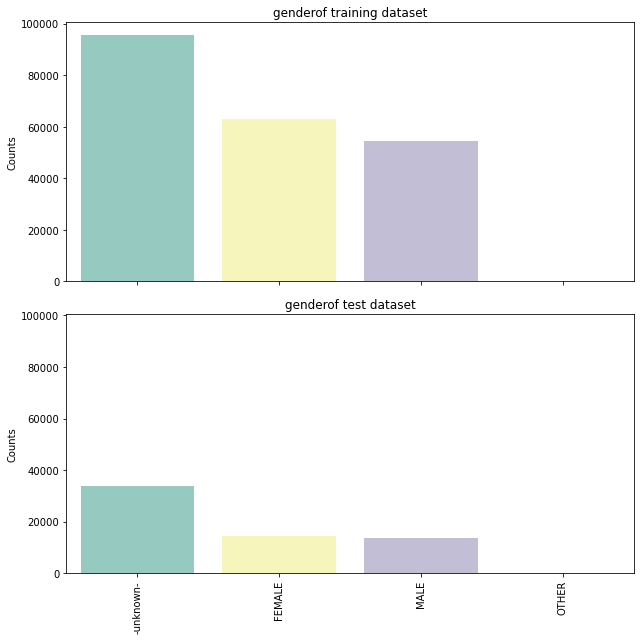

In [21]:
lookup_feature('gender', saveimg = True)

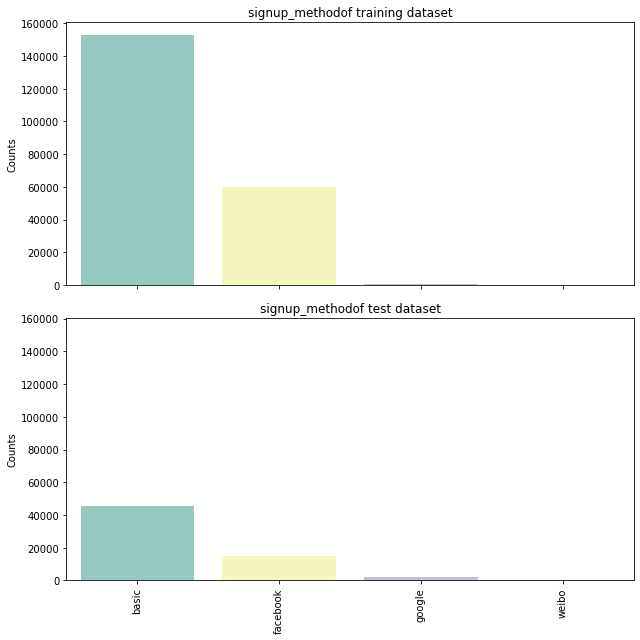

In [22]:
lookup_feature('signup_method')

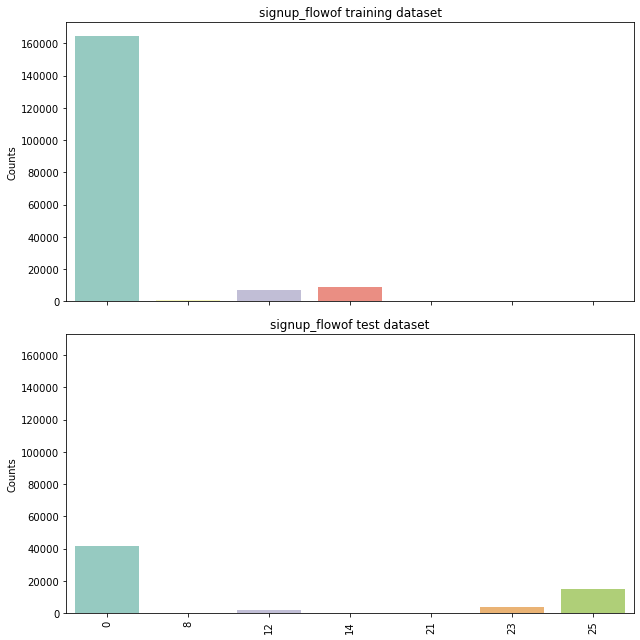

In [23]:
lookup_feature('signup_flow')

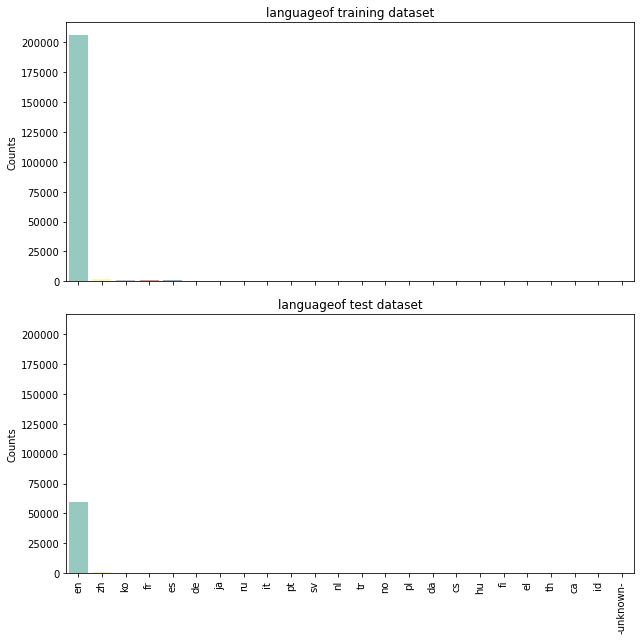

In [24]:
lookup_feature('language')

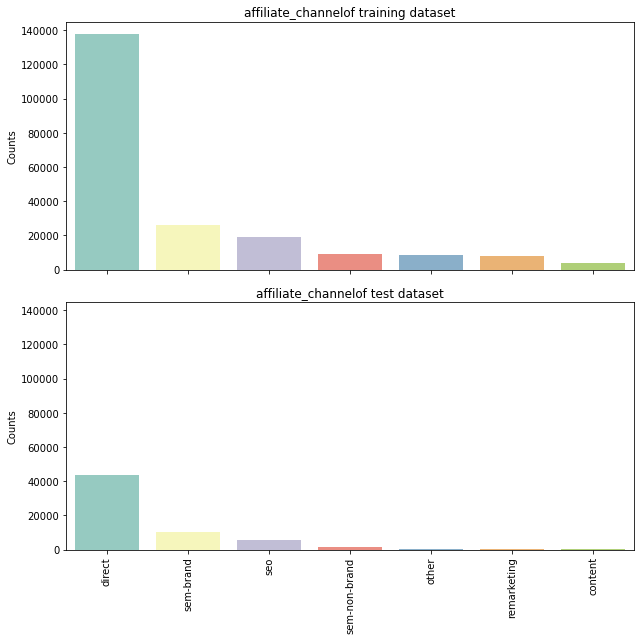

In [25]:
lookup_feature('affiliate_channel')

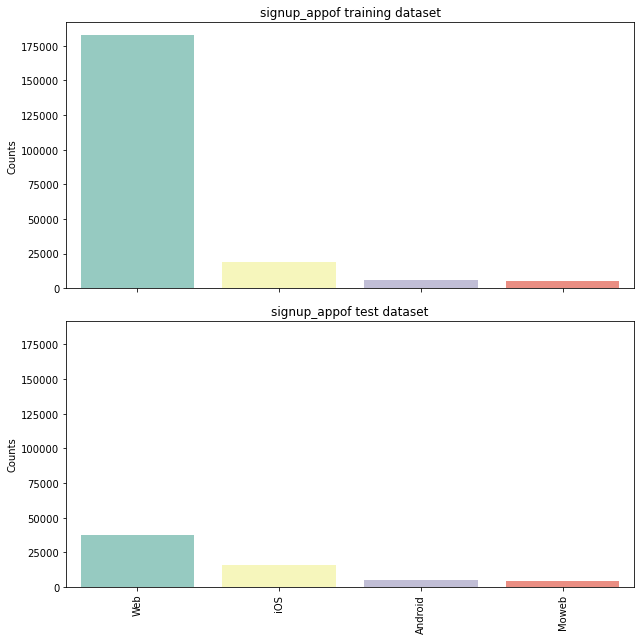

In [26]:
lookup_feature('signup_app')

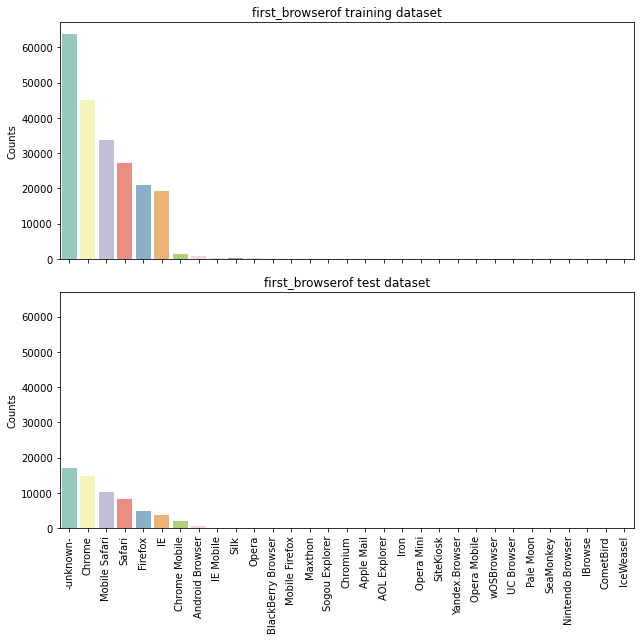

In [27]:
lookup_feature('first_browser')

#### 把首次活跃时间变成时间格式

In [28]:
train['timestamp_first_active']

0         20090319043255
1         20090523174809
2         20090609231247
3         20091031060129
4         20091208061105
               ...      
213446    20140630235636
213447    20140630235719
213448    20140630235754
213449    20140630235822
213450    20140630235824
Name: timestamp_first_active, Length: 213451, dtype: int64

In [29]:
from dateutil.parser import parse

In [30]:
# time.strptime(d, "%Y-%m-%d %H:%M:%S") 
# 不是一个东西

In [31]:
# 一串数字转时间 先变str,再parse()转换
# 例子:20090319043255 --> 2009-03-19 04:32:55
train['timestamp_first_active'] = train['timestamp_first_active']. \
apply(lambda x:parse(str(x)))

In [32]:
train['timestamp_first_active']

0        2009-03-19 04:32:55
1        2009-05-23 17:48:09
2        2009-06-09 23:12:47
3        2009-10-31 06:01:29
4        2009-12-08 06:11:05
                 ...        
213446   2014-06-30 23:56:36
213447   2014-06-30 23:57:19
213448   2014-06-30 23:57:54
213449   2014-06-30 23:58:22
213450   2014-06-30 23:58:24
Name: timestamp_first_active, Length: 213451, dtype: datetime64[ns]

In [33]:
# train['timestamp_first_active'] = 
# train['timestamp_first_active']    